# LSTM

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

In [ ]:
df = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_train_2015.csv', index_col=0, parse_dates=True)
df = df.asfreq('h')

In [ ]:
df = df.between_time('07:00:00','18:00:00')

In [ ]:
df.head()

,DC,PAAVG1H,PAMAX1H,PAMIN1H,PRSUM1H,RHAVG1H,RHMAX1H,RHMIN1H,SRDIFAVG1H,SRDIFMAX1H,SRDIFMIN1H,SRDIFSUM1H,SRGLOAVG1H,SRGLOMAX1H,SRGLOMIN1H,SRGLOSUM1H,TAAVG1H,TAMAX1H,TAMIN1H,TS1AVG1H,TS1MAX1H,TS1MIN1H,TS2AVG1H,TS2MAX1H,TS2MIN1H,TS3AVG1H,TS3MAX1H,TS3MIN1H,TS4AVG1H,TS4MAX1H,TS4MIN1H,TS5AVG1H,TS5MAX1H,TS5MIN1H,TS6AVG1H,TS6MAX1H,TS6MIN1H,TS7AVG1H,TS7MAX1H,TS7MIN1H,WD1HA,WD1HX,WDGM,WGD1HX,WGDH,WR1H,WS1HA,WS1HM,WS1HX
Local_Time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 07:00:00,13.0,742.8,743.1,742.6,0.0,95,97,91,14.0,35.0,1.0,852.0,15.0,39.0,0.0,924.0,9.9,10.7,9.1,8.6,9.4,7.5,9.0,9.8,8.0,10.0,10.6,9.3,11.8,12.0,11.7,13.8,13.8,13.8,15.0,15.0,15.0,15.0,15.0,15.0,54,94,14,60.0,6.0,35.0,2.4,0.9,3.9
2015-01-01 08:00:00,13.9,743.5,743.7,743.1,0.0,94,96,89,97.0,145.0,37.0,5836.0,107.0,162.0,40.0,6404.0,10.6,12.2,9.5,10.3,11.9,9.3,10.6,12.0,9.7,11.1,12.1,10.5,12.1,12.3,12.0,13.7,13.8,13.7,15.0,15.0,15.0,15.0,15.0,15.0,42,91,54,46.0,7.0,37.0,2.5,0.4,4.6
2015-01-01 09:00:00,15.0,743.8,743.9,743.7,0.0,84,89,76,224.0,514.0,120.0,13469.0,394.0,781.0,136.0,23646.0,13.5,15.1,12.2,13.2,14.9,11.9,13.1,14.4,12.0,12.8,13.6,12.1,12.6,12.9,12.3,13.7,13.7,13.7,15.0,15.0,15.0,15.0,15.0,15.0,59,111,42,69.0,8.0,49.0,3.3,0.0,5.8
2015-01-01 10:00:00,15.0,743.7,743.9,743.4,0.0,68,79,57,219.0,329.0,97.0,13163.0,728.0,1197.0,373.0,43654.0,16.3,18.1,15.1,17.2,19.7,14.9,16.4,18.5,14.4,14.8,16.1,13.6,13.3,13.8,12.9,13.7,13.7,13.7,15.0,15.0,15.0,15.0,15.0,15.0,40,175,41,28.0,9.0,66.0,4.4,0.0,8.4
2015-01-01 11:00:00,14.7,743.2,743.4,742.8,0.0,62,66,58,365.0,471.0,284.0,21929.0,428.0,667.0,303.0,25688.0,17.2,18.4,16.7,18.8,20.0,18.0,18.0,18.7,17.4,16.0,16.2,15.9,14.0,14.2,13.8,13.8,13.8,13.7,15.0,15.0,15.0,15.0,15.0,15.0,35,153,26,29.0,10.0,61.0,4.0,0.0,8.1


In [ ]:
df = df[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]

In [ ]:
df.head()

,SRGLOAVG1H,TAMAX1H,TAMIN1H,WS1HX,WS1HA,RHMIN1H,RHMAX1H
Local_Time,,,,,,,
2015-01-01 07:00:00,15.0,10.7,9.1,3.9,2.4,91,97
2015-01-01 08:00:00,107.0,12.2,9.5,4.6,2.5,89,96
2015-01-01 09:00:00,394.0,15.1,12.2,5.8,3.3,76,89
2015-01-01 10:00:00,728.0,18.1,15.1,8.4,4.4,57,79
2015-01-01 11:00:00,428.0,18.4,16.7,8.1,4.0,58,66


In [ ]:
np.where(df=='/')

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
df_test = pd.read_csv('./drive/MyDrive/DatosInvestigacion/final_test_2015.csv', index_col=0, parse_dates=True)
df_test = df_test.asfreq('h')

In [ ]:
df_test = df_test[['SRGLOAVG1H','TAMAX1H','TAMIN1H','WS1HX','WS1HA','RHMIN1H','RHMAX1H']]
df_test = df_test.between_time('07:00:00','18:00:00')

## Una variable de entrada

Se toma la serie de tiempo de la radiación solar global.

In [ ]:
RSG = df['SRGLOAVG1H'].values

In [ ]:
RSG = np.reshape(RSG,(-1,1))

In [ ]:
RSG[:5]

array([[ 15.],
       [107.],
       [394.],
       [728.],
       [428.]])

In [ ]:
RSG_test = df_test['SRGLOAVG1H'].values
RSG_test = np.reshape(RSG_test,(-1,1))

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
scaler = MinMaxScaler()

In [ ]:
scaler.fit(RSG)

MinMaxScaler()

In [ ]:
scaled_train = scaler.transform(RSG)
scaled_test = scaler.transform(RSG_test)

In [ ]:
scaled_train[0]

array([0.01069959])

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

Se definen los batches para el entrenamiento.

In [ ]:
n_input = 12 # horas hacia atrás
n_features = 1 # hora predicha
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [ ]:
X,y = generator[0]

In [ ]:
print(f'Datos: \n{X.flatten()}')
print(f'Predicción: \n {y}')

Datos: 
[0.01069959 0.08641975 0.32263374 0.59753086 0.35061728 0.33004115
 0.581893   0.32510288 0.4872428  0.25185185 0.11028807 0.02716049]
Predicción: 
 [[0.01399177]]


## Creación del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
model.fit(generator,epochs=5)

Epoch 1/5
3492/3492 [==============================] - 35s 10ms/step - loss: 0.0201
Epoch 2/5
3492/3492 [==============================] - 32s 9ms/step - loss: 0.0141
Epoch 3/5
3492/3492 [==============================] - 31s 9ms/step - loss: 0.0135
Epoch 4/5
3492/3492 [==============================] - 30s 9ms/step - loss: 0.0131
Epoch 5/5
3492/3492 [==============================] - 29s 8ms/step - loss: 0.0127


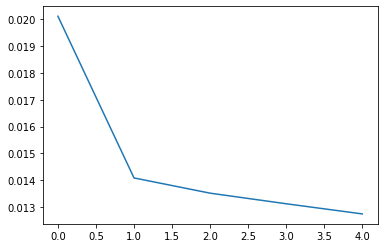

In [ ]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
X.shape

(1, 12, 1)

In [ ]:
# Necesitaremos las últimas 12 horas del conjunto de entrenamiento para predecir el 1er mes en el conjunto de prueba
first_eval_batch = scaled_train[-12:]

In [ ]:
first_eval_batch

array([[0.02057613],
       [0.07572016],
       [0.14320988],
       [0.15802469],
       [0.35061728],
       [0.46584362],
       [0.54238683],
       [0.36872428],
       [0.28559671],
       [0.14979424],
       [0.10041152],
       [0.02304527]])

In [ ]:
first_eval_batch.shape

(12, 1)

In [ ]:
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))

In [ ]:
first_eval_batch.shape

(1, 12, 1)

Valor predicho y valor real.

In [ ]:
model.predict(first_eval_batch)[0]

array([0.00511046], dtype=float32)

In [ ]:
scaled_test[0]

array([0.03045267])

Se obtienen las precdicciones de una semana

In [ ]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(12*7):
    
    # obtener la predicción ([0] es para obtener solo el número en lugar de [matriz])
    current_pred = model.predict(current_batch)[0]
    
    # guardar la predicción
    test_predictions.append(current_pred) 
    
    # actualizar el lote para incluir ahora la predicción y soltar primer valor
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [ ]:
true_predictions = scaler.inverse_transform(test_predictions)

In [ ]:
df_plot = pd.DataFrame()

In [ ]:
df_plot['RSG'] =  df_test['SRGLOAVG1H'][:12*7]

In [ ]:
df_plot['predictions'] = true_predictions

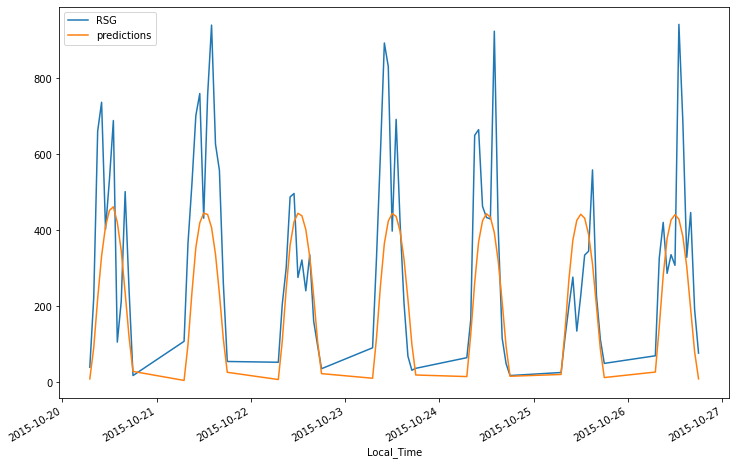

In [ ]:
df_plot.plot(figsize=(12,8))

Salvar el modelo

In [ ]:
model.save('RSG_model.h5')